In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 602ms/step - loss: 0.0532
Average validation loss: 0.45614659786224365
4/4 [==============================] - 6s 617ms/step - loss: 0.0532 - val_loss: 0.4561
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 598ms/step - loss: 0.0419 - val_loss: 0.4561
Average validation loss: 0.47043484449386597
4/4 [==============================] - 8s 612ms/step - loss: 0.0419 - val_loss: 0.4633
Epoch 3/10
4/4 [==============================] - 11s 609ms/step - loss: 0.0333 - val_loss: 0.4633
Average validation loss: 0.29992443323135376
4/4 [==============================] - 11s 622ms/step - loss: 0.0333 - val_loss: 0.4088
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_5.pth'.
Epoch 4/10
4/4 [==============================] - 13s 604ms/

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 800ms/step - loss: 0.0028
Average validation loss: 1.4000531983748843e-10
8/8 [==============================] - 7s 814ms/step - loss: 0.0028 - val_loss: 1.4001e-10
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 798ms/step - loss: 0.0028 - val_loss: 1.4001e-10
Average validation loss: 3.2623543972931657e-06
8/8 [==============================] - 13s 812ms/step - loss: 0.0028 - val_loss: 1.6312e-06
Epoch 3/10
8/8 [==============================] - 19s 792ms/step - loss: 0.0027 - val_loss: 1.6312e-06
Average validation loss: 2.6768447241920512e-05
8/8 [==============================] - 20s 810ms/step - loss: 0.0027 - val_loss: 1.0010e-05
Epoch 4/10
8/8 [==============================] - 26s 803ms/step - loss: 0.0027 - val_loss: 1.0010e-05
Average validation loss: 6.673082361885463e-05
8/8 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 812ms/step - loss: 0.0035
Average validation loss: 0.19998810702350053
12/12 [==============================] - 10s 824ms/step - loss: 0.0035 - val_loss: 0.2000
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 20s 820ms/step - loss: 0.0032 - val_loss: 0.2000
Average validation loss: 0.09631042698799767
12/12 [==============================] - 20s 833ms/step - loss: 0.0032 - val_loss: 0.1481
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 30s 820ms/step - loss: 0.0032 - val_loss: 0.1481
Average validation loss: 0.07595730944602981
12/12 [==============================] - 30s 834ms/step - loss: 0.0032 - val_loss: 0.1241
Saved model weights to 'c:\Users\user\Desk

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 13s 782ms/step - loss: 0.0025
Average validation loss: 0.2006170079112053
16/16 [==============================] - 13s 795ms/step - loss: 0.0025 - val_loss: 0.2006
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 26s 802ms/step - loss: 0.0023 - val_loss: 0.2006
Average validation loss: 0.10210062796288638
16/16 [==============================] - 26s 814ms/step - loss: 0.0023 - val_loss: 0.1514
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 38s 791ms/step - loss: 0.0023 - val_loss: 0.1514
Average validation loss: 0.02666145481748572
16/16 [==============================] - 39s 805ms/step - loss: 0.0023 - val_loss: 0.1098
Saved model weights to 'c:\Users\user\Deskt

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 767ms/step - loss: 0.0019
Average validation loss: 0.033000287134200335
20/20 [==============================] - 16s 779ms/step - loss: 0.0019 - val_loss: 0.0330
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 30s 729ms/step - loss: 0.0017 - val_loss: 0.0330
Average validation loss: 0.017184030571661423
20/20 [==============================] - 30s 741ms/step - loss: 0.0017 - val_loss: 0.0251
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_25.pth'.
Epoch 3/10
20/20 [==============================] - 45s 719ms/step - loss: 0.0016 - val_loss: 0.0251
Average validation loss: 0.02474561843941956
20/20 [==============================] - 45s 730ms/step - loss: 0.0016 - val_loss: 0.0250
Epoch 4/10
20/20 [======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 724ms/step - loss: 0.0021
Average validation loss: 0.04089571504543225
24/24 [==============================] - 18s 735ms/step - loss: 0.0021 - val_loss: 0.0409
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 738ms/step - loss: 0.0018 - val_loss: 0.0409
Average validation loss: 0.011189344804733992
24/24 [==============================] - 36s 749ms/step - loss: 0.0018 - val_loss: 0.0260
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 714ms/step - loss: 0.0015 - val_loss: 0.0260
Average validation loss: 0.010159853147342801
24/24 [==============================] - 53s 724ms/step - loss: 0.0015 - val_loss: 0.0207
Saved model weights to 'c:\Users\user\De

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 29s 725ms/step - loss: 0.0027
Average validation loss: 0.023006886430084705
40/40 [==============================] - 30s 738ms/step - loss: 0.0027 - val_loss: 0.0230
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 737ms/step - loss: 0.0023 - val_loss: 0.0230
Average validation loss: 0.138421431183815
40/40 [==============================] - 60s 749ms/step - loss: 0.0023 - val_loss: 0.0807
Epoch 3/10
40/40 [==============================] - 89s 744ms/step - loss: 0.0021 - val_loss: 0.0807
Average validation loss: 0.03540924210101366
40/40 [==============================] - 90s 756ms/step - loss: 0.0021 - val_loss: 0.0656
Epoch 4/10
40/40 [==============================] - 119s 734ms/step - loss: 0.0020 - val_loss: 0.0656
Average validation loss: 0.027397697791457176
40/40 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 34s 718ms/step - loss: 0.0017
Average validation loss: 0.010191263028636635
48/48 [==============================] - 35s 729ms/step - loss: 0.0017 - val_loss: 0.0102
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 744ms/step - loss: 0.0014 - val_loss: 0.0102
Average validation loss: 0.0072356698564609205
48/48 [==============================] - 71s 756ms/step - loss: 0.0014 - val_loss: 0.0087
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 107s 729ms/step - loss: 0.0012 - val_loss: 0.0087
Average validation loss: 0.030096162723538062
48/48 [==============================] - 107s 740ms/step - loss: 0.0012 - val_loss: 0.0158
Epoch 4/10
48/48 [==================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 733ms/step - loss: 0.0019
Average validation loss: 0.011632469053469652
56/56 [==============================] - 42s 745ms/step - loss: 0.0019 - val_loss: 0.0116
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 716ms/step - loss: 0.0015 - val_loss: 0.0116
Average validation loss: 0.013440575741226658
56/56 [==============================] - 82s 727ms/step - loss: 0.0015 - val_loss: 0.0125
Epoch 3/10
56/56 [==============================] - 123s 720ms/step - loss: 0.0012 - val_loss: 0.0125
Average validation loss: 0.01219735894218196
56/56 [==============================] - 123s 732ms/step - loss: 0.0012 - val_loss: 0.0124
Epoch 4/10
56/56 [==============================] - 164s 717ms/step - loss: 0.0011 - val_loss: 0.0124
Average validation loss: 0.018491984407735553
56/56 [=======================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 47s 729ms/step - loss: 0.0014
Average validation loss: 0.008251059585326459
64/64 [==============================] - 47s 741ms/step - loss: 0.0014 - val_loss: 0.0083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 716ms/step - loss: 0.0011 - val_loss: 0.0083
Average validation loss: 0.007687155271490553
64/64 [==============================] - 94s 727ms/step - loss: 0.0011 - val_loss: 0.0080
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 716ms/step - loss: 9.5358e-04 - val_loss: 0.0080
Average validation loss: 0.024159076063243634
64/64 [==============================] - 141s 728ms/step - loss: 9.5358e-04 - val_loss: 0.0134
Epoch 4/10
64/64 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 712ms/step - loss: 0.0012
Average validation loss: 0.01042778701392106
72/72 [==============================] - 52s 723ms/step - loss: 0.0012 - val_loss: 0.0104
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 716ms/step - loss: 9.4539e-04 - val_loss: 0.0104
Average validation loss: 0.00761351745394576
72/72 [==============================] - 104s 727ms/step - loss: 9.4539e-04 - val_loss: 0.0090
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 157s 723ms/step - loss: 7.8713e-04 - val_loss: 0.0090
Average validation loss: 0.008979731485144131
72/72 [==============================] - 157s 735ms/step - loss: 7.8713e-04 - val_loss: 0.0090
Epoch 4/10
72/72 [===

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 721ms/step - loss: 0.0011
Average validation loss: 0.006946697848616168
80/80 [==============================] - 59s 732ms/step - loss: 0.0011 - val_loss: 0.0069
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 116s 718ms/step - loss: 8.8966e-04 - val_loss: 0.0069
Average validation loss: 0.007267703907564283
80/80 [==============================] - 117s 729ms/step - loss: 8.8966e-04 - val_loss: 0.0071
Epoch 3/10
80/80 [==============================] - 174s 716ms/step - loss: 7.6313e-04 - val_loss: 0.0071
Average validation loss: 0.005576326459413394
80/80 [==============================] - 175s 727ms/step - loss: 7.6313e-04 - val_loss: 0.0066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_100.pth'.
Epoch 4/10
80/80 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 720ms/step - loss: 0.0016
Average validation loss: 0.01913998120042093
96/96 [==============================] - 70s 732ms/step - loss: 0.0016 - val_loss: 0.0191
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 139s 712ms/step - loss: 0.0013 - val_loss: 0.0191
Average validation loss: 0.016329160129192388
96/96 [==============================] - 140s 723ms/step - loss: 0.0013 - val_loss: 0.0177
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 208s 714ms/step - loss: 0.0011 - val_loss: 0.0177
Average validation loss: 0.022032261258909586
96/96 [==============================] - 210s 727ms/step - loss: 0.0011 - val_loss: 0.0192
Epoch 4/10
96/96 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 86s 715ms/step - loss: 0.0014
Average validation loss: 0.006805673645188411
120/120 [==============================] - 87s 727ms/step - loss: 0.0014 - val_loss: 0.0068
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 173s 714ms/step - loss: 0.0011 - val_loss: 0.0068
Average validation loss: 0.006472744598674278
120/120 [==============================] - 174s 726ms/step - loss: 0.0011 - val_loss: 0.0066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 261s 718ms/step - loss: 9.2468e-04 - val_loss: 0.0066
Average validation loss: 0.00668851567007395
120/120 [==============================] - 262s 729ms/step - loss: 9.2468e-04 - val_loss: 0.0067
Epoch 4/10
120

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 104s 720ms/step - loss: 0.0011
Average validation loss: 0.006736520392627831
144/144 [==============================] - 105s 732ms/step - loss: 0.0011 - val_loss: 0.0067
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 715ms/step - loss: 9.1985e-04 - val_loss: 0.0067
Average validation loss: 0.0070340630570624825
144/144 [==============================] - 210s 726ms/step - loss: 9.1985e-04 - val_loss: 0.0069
Epoch 3/10
144/144 [==============================] - 314s 719ms/step - loss: 7.8214e-04 - val_loss: 0.0069
Average validation loss: 0.006445805940995604
144/144 [==============================] - 315s 731ms/step - loss: 7.8214e-04 - val_loss: 0.0067
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_180.pth'.
Ep

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 116s 722ms/step - loss: 7.5558e-04
Average validation loss: 0.008400965305924046
160/160 [==============================] - 117s 733ms/step - loss: 7.5558e-04 - val_loss: 0.0084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 232s 716ms/step - loss: 6.5086e-04 - val_loss: 0.0084
Average validation loss: 0.005182193917392342
160/160 [==============================] - 234s 728ms/step - loss: 6.5086e-04 - val_loss: 0.0068
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 349s 717ms/step - loss: 5.8565e-04 - val_loss: 0.0068
Average validation loss: 0.004880099258312488
160/160 [==============================] - 351s 729ms/step - loss: 5.8565e-04 - val_loss: 0.

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 720ms/step - loss: 0.0015
Average validation loss: 0.00834212263119517
200/200 [==============================] - 146s 731ms/step - loss: 0.0015 - val_loss: 0.0083
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 717ms/step - loss: 0.0012 - val_loss: 0.0083
Average validation loss: 0.006080890419079879
200/200 [==============================] - 292s 728ms/step - loss: 0.0012 - val_loss: 0.0072
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 435s 715ms/step - loss: 0.0010 - val_loss: 0.0072
Average validation loss: 0.00650440029314256
200/200 [==============================] - 437s 726ms/step - loss: 0.0010 - val_loss: 0.0070
Epoch 4/10
200/200 [=

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:51 - loss: 3.7534e-04

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 722ms/step - loss: 9.8225e-04
Average validation loss: 0.0073176621053846706
240/240 [==============================] - 176s 733ms/step - loss: 9.8225e-04 - val_loss: 0.0073
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 347s 713ms/step - loss: 7.8149e-04 - val_loss: 0.0073
Average validation loss: 0.009459425057357862
240/240 [==============================] - 350s 724ms/step - loss: 7.8149e-04 - val_loss: 0.0084
Epoch 3/10
240/240 [==============================] - 521s 715ms/step - loss: 6.8594e-04 - val_loss: 0.0084
Average validation loss: 0.007616866085574732
240/240 [==============================] - 524s 726ms/step - loss: 6.8594e-04 - val_loss: 0.0081
Epoch 4/10
240/240 [==============================] - 696s 717ms/step - loss: 6.2536e-04 - val_loss: 0.0081
Average validation loss: 0.

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.051090384219808736, 0.13064596819911703, 0.1155063110262501, 0.055318184454446334, 0.03193019765337518, 0.014822377427194168, 0.02748709000955053, 0.034220019122079066, 0.013340038488781797, 0.0063328314118989, 0.005563534100251807, 0.005106004847199843, 0.00882665240447962, 0.009616498411911535, 0.005764513756306136, 0.0039752603951915, 0.006000844819065221, 0.005713334349935503]
std_val_losses =  [0.10851646974350596, 0.13709615851558946, 0.09068258029803983, 0.052276018931118814, 0.054935322651377044, 0.014171194814760417, 0.034995850668116994, 0.1058488147088872, 0.01492244596475925, 0.0036478491956633808, 0.0025656944880035923, 0.0039713909261866395, 0.007619606670096617, 0.01990392060508848, 0.004675435232200853, 0.0015359479843800193, 0.004216764619840082, 0.004437859696374232]


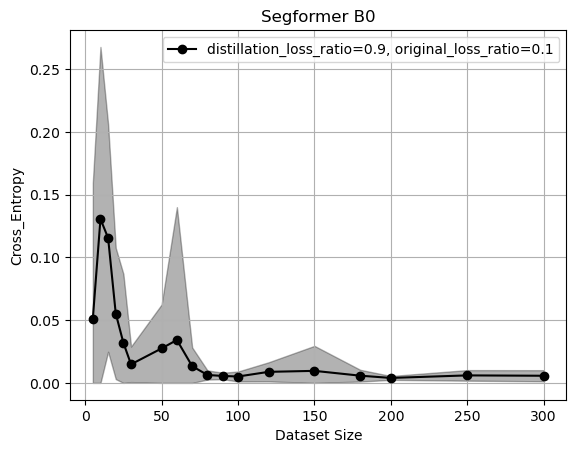

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()